# Extract MILC output
- Dec 28, 2021

## Description of columns in parse script : 



- Solve time =  2 x sum of all mass-solve times


- quda-total-time = solve-time + mg-setup + epsilon

- summed_time = quda_total_time + contractions + epsilon

- milc_total_time = summed_time + err

In [1]:
! hostname

jupyter-venkitesh


In [2]:
import os, glob
import subprocess as sp
import numpy as np
import shutil

import re

import pandas as pd

import matplotlib.pyplot as plt
from ipywidgets import *

import itertools

In [3]:
%matplotlib widget

In [8]:
top_dir='/gpfs/alpine/lgt104/proj-shared/ayyar/runs_frontier/runs_jan27_2023'

op_dict={
'cg_old_summit':'/gpfs/alpine/lgt104/proj-shared/ayyar/runs_summit/parse_timings/output-cg.kpp',
'cg_new_summit':'/gpfs/alpine/lgt104/proj-shared/ayyar/runs_summit/runs_feb3_2023/cg_run/output-full-cg_72nodes.kpp',
'cg_crusher_144':'~/mg_output_files/output-cg_144_crusher.kpp',
'cg_frontier_192':' ~/mg_output_files/output-cg_192_frontier.kpp',

'mg_summit_old_drp':'/gpfs/alpine/lgt104/proj-shared/ayyar/runs_summit/runs_march14_2022/output-full-drop-xfast-1536vec-run-1.kpp',
'mg_summit_old':'/gpfs/alpine/lgt104/proj-shared/ayyar/runs_summit/runs_march14_2022/output-full-xfast-1536vec-run-1.kpp',
'mg_summit_old2':'/gpfs/alpine/lgt104/proj-shared/ayyar/runs_summit/runs_feb3_2023/mg_run1/output-full-xfast-1536vec-run-2.kpp',
'summit_144_savingNN'   :'/gpfs/alpine/lgt104/proj-shared/ayyar/runs_summit/runs_june8_2023/run_144/output-full_1_savingNN.kpp',
# 'summit_144_loadingNN':'',
    
'old_crusher_2_hprec':'/gpfs/alpine/lgt104/proj-shared/ayyar/runs_crusher/runs_feb2_2023_mpich8.1.12/output-full-2.kpp',
'crusher_latest_144_savingNN':'~/mg_output_files/output-full_1_savingNN.kpp',
'crusher_latest_144_readingNN':'~/mg_output_files/output-full_2_readingNN.kpp',
'frontier_144_savingNN':'~/mg_output_files/output-full_1_savingNN_144_frontier.kpp',

# 'summit_192_wrong_ip': '/gpfs/alpine/lgt104/proj-shared/ayyar/runs_summit/runs_june8_2023/run_192/output-full-run-2_wrong_mgparams.kpp',
'summit_192': '/gpfs/alpine/lgt104/proj-shared/ayyar/runs_summit/runs_june8_2023/run_192/output-full-run-1.kpp',

# 'frontier_192_wrong_ip': '~/output-full_11_final_complete.kpp',
'frontier_192': '~/mg_output_files/output-full_1_correct_ip.kpp',
}

# list(op_dict.keys())
# list(op_dict.values())

In [9]:
# cmd='./parse.sh %s mg '%(fname1)
# op=sp.check_output(cmd,shell=True,text=True)

## New way in python
# cmd=['./parse.sh',' '+fname1,'mg', ' > op0.out']
# print(cmd)
# op=sp.run(cmd,check=True,capture_output=True,text=True).stdout


In [10]:
## Parse output files

op_files=[]
for count,fl in enumerate(list(op_dict.values())):
    op_file='op%s.out'%(count)
    run_type='cg' if count<4 else 'mg'   ## Assume first 3 runs are cg, rest mg ##!
    print(fl,run_type)
    cmd='./parse.sh %s %s > %s'%(fl,run_type,op_file)
    op=sp.check_output(cmd,shell=True,text=True)
    
    ## Run bash script to parse output
    # cmd=['./parse.sh',fl,run_type,' > op%s.out'%(count+1)]
    # op=sp.run(cmd,check=True,capture_output=True,text=True)
    
    print(cmd)
    print(op)
    ## Append output file names to list
    op_files.append(op_file)

/gpfs/alpine/lgt104/proj-shared/ayyar/runs_summit/parse_timings/output-cg.kpp cg
./parse.sh /gpfs/alpine/lgt104/proj-shared/ayyar/runs_summit/parse_timings/output-cg.kpp cg > op0.out

/gpfs/alpine/lgt104/proj-shared/ayyar/runs_summit/runs_feb3_2023/cg_run/output-full-cg_72nodes.kpp cg
./parse.sh /gpfs/alpine/lgt104/proj-shared/ayyar/runs_summit/runs_feb3_2023/cg_run/output-full-cg_72nodes.kpp cg > op1.out

~/mg_output_files/output-cg_144_crusher.kpp cg
./parse.sh ~/mg_output_files/output-cg_144_crusher.kpp cg > op2.out

 ~/mg_output_files/output-cg_192_frontier.kpp cg
./parse.sh  ~/mg_output_files/output-cg_192_frontier.kpp cg > op3.out

/gpfs/alpine/lgt104/proj-shared/ayyar/runs_summit/runs_march14_2022/output-full-drop-xfast-1536vec-run-1.kpp mg
./parse.sh /gpfs/alpine/lgt104/proj-shared/ayyar/runs_summit/runs_march14_2022/output-full-drop-xfast-1536vec-run-1.kpp mg > op4.out

/gpfs/alpine/lgt104/proj-shared/ayyar/runs_summit/runs_march14_2022/output-full-xfast-1536vec-run-1.kpp mg
.

In [11]:
names=list(op_dict.keys())

gpus=[0 for i in range(0,len(names))]
for count,i in enumerate(names):
    if count<2: gpus[count]=int(864/2)
    else: gpus[count]=864
    
df_data=pd.DataFrame([])

count=0
for op_file, name,gpu in zip(op_files,names,gpus):
    print(op_file,name)
    with open(op_file,'r') as f:
        lst=f.readlines()

    print(lst)
    dict_values={}
    dict_values['name']=name
    dict_values['gpus']=int(gpu)
    # Add masses
    keys=lst[0].rstrip('\n').split(' ')
    vals=lst[1].rstrip('\n').split(' ')

    # Add timings
    keys+=lst[2].rstrip('\n').split(' ')
    vals+=lst[3].rstrip('\n').split(' ')

    # Add values to dictionary
    for k,v in zip(keys,vals):
        dict_values[k]=np.float64(v)

    # df_data=df_data.append(dict_values,ignore_index=True)
    df_data=pd.concat([df_data,pd.DataFrame(dict_values,index=[count])])
    count+=1

cols=['name', 'gpus','startup', 'loading', 'mg-setup',
       'make/save-src', 'mass-01', 'mass-02', 'mass-03', 'mass-04-10', 'mass-01-10',
       'mass-11-20', 'solve-time','contractions', 'quda-total-time','summed-time', 'error',
       'milc-total-time']

df_data=df_data[cols].copy()

op0.out cg_old_summit
['mass-01-10 mass-11-20\n', '1.3709695999999999e+03 1.6527176299999996e+02\n', 'startup loading mg-setup solve-time make/save-src contractions summed-time quda-total-time milc-total-time error\n', '7.172779e+01 6.197862e+02 0 3.0724827259999997e+03 5.905079e+01 4.168595e+02 4.2399070059999995e+03 3275.602 4.263153e+03 2.324599400000079e+01\n']
op1.out cg_new_summit
['mass-01-10 mass-11-20\n', '1.4316558500000001e+03 2.7283350900000011e+02\n', 'startup loading mg-setup solve-time make/save-src contractions summed-time quda-total-time milc-total-time error\n', '7.996576e+01 6.072320e+02 0 3.4089787180000003e+03 2.587562e-01 4.092303e+02 4.5056655342000004e+03 3757.776 4.590010e+03 8.434446579999985e+01\n']
op2.out cg_crusher_144
['mass-01-10 mass-11-20\n', '3.9220819000000000e+02 5.5289390299999980e+01\n', 'startup loading mg-setup solve-time make/save-src contractions summed-time quda-total-time milc-total-time error\n', '3.729403e+01 6.951410e+02 0 8.9499516059999

In [12]:
df_data

,name,gpus,startup,loading,mg-setup,make/save-src,mass-01,mass-02,mass-03,mass-04-10,mass-01-10,mass-11-20,solve-time,contractions,quda-total-time,summed-time,error,milc-total-time
0,cg_old_summit,432,71.72779,619.7862,0.000,59.050790,NaN,NaN,NaN,NaN,1370.969600,165.271763,3072.482726,416.8595,3275.602,4239.907006,23.245994,4263.153
1,cg_new_summit,432,79.96576,607.2320,0.000,0.258756,NaN,NaN,NaN,NaN,1431.655850,272.833509,3408.978718,409.2303,3757.776,4505.665534,84.344466,4590.010
2,cg_crusher_144,864,37.29403,695.1410,0.000,24.369050,NaN,NaN,NaN,NaN,392.208190,55.289390,894.995161,329.7167,979.632,1981.515941,17.702059,1999.218
3,cg_frontier_192,864,93.97120,702.9465,0.000,5.348363,NaN,NaN,NaN,NaN,586.894355,103.030642,1379.849995,405.4270,1481.877,2587.543058,26.925942,2614.469
4,mg_summit_old_drp,864,68.78589,219.8139,1321.480,80.249010,26.410876,22.684569,22.347331,172.823485,NaN,95.581006,679.694533,185.9288,2021.795,2555.952133,24.836867,2580.789
5,mg_summit_old,864,68.89721,183.6686,1573.230,82.030770,23.328819,20.972033,22.804720,169.685265,NaN,92.148932,657.879539,191.2514,2283.090,2756.957519,56.200481,2813.158
6,mg_summit_old2,864,78.65395,217.6886,1593.850,82.630040,20.281821,16.588694,17.250298,172.063075,NaN,89.272249,630.912275,185.6358,2334.469,2789.370665,119.125335,2908.496
7,summit_144_savingNN,864,84.89080,303.3417,6240.440,111.549900,18.804819,14.653286,15.983072,235.582000,NaN,91.022273,752.090898,180.5583,7289.999,7672.871598,147.206402,7820.078
8,old_crusher_2_hprec,864,48.23773,822.7423,4040.290,73.978930,26.333695,20.974092,21.218190,148.638410,NaN,66.783495,567.895762,417.2004,4744.151,5970.345122,83.552878,6053.898
9,crusher_latest_144_savingNN,864,32.90049,621.4185,5284.530,25.099540,25.610843,20.008936,18.849449,117.502115,NaN,60.959802,485.862291,324.4752,5786.845,6774.286021,21.643979,6795.930




- Solve time =  2 x sum of all mass-solve times


- quda-total-time = solve-time + mg-setup + epsilon

- summed_time = quda_total_time + contractions + epsilon

- milc_total_time = summed_time + err




In [13]:
# df_data.iloc[[3,10,11]]
# df_data.iloc[[2,5,7,8,9]]
# df_data.iloc[[3,8,11]]

In [14]:
df=df_data.copy()
nmax=max(df.gpus.values)
df['gpu_factor']=df.apply(lambda row: row.gpus/nmax, axis=1)

times_lst=['mass-01', 'mass-02', 'mass-03', 'mass-04-10',
       'mass-11-20', 'startup', 'loading', 'mg-setup', 'solve-time',
       'make/save-src', 'contractions', 'quda-total-time','summed-time', 'error',
       'milc-total-time']

# for col in times_lst:
    # df[col]=df[col]*df['gpu_factor']
    
df[:]

,name,gpus,startup,loading,mg-setup,make/save-src,mass-01,mass-02,mass-03,mass-04-10,mass-01-10,mass-11-20,solve-time,contractions,quda-total-time,summed-time,error,milc-total-time,gpu_factor
0,cg_old_summit,432,71.72779,619.7862,0.000,59.050790,NaN,NaN,NaN,NaN,1370.969600,165.271763,3072.482726,416.8595,3275.602,4239.907006,23.245994,4263.153,0.5
1,cg_new_summit,432,79.96576,607.2320,0.000,0.258756,NaN,NaN,NaN,NaN,1431.655850,272.833509,3408.978718,409.2303,3757.776,4505.665534,84.344466,4590.010,0.5
2,cg_crusher_144,864,37.29403,695.1410,0.000,24.369050,NaN,NaN,NaN,NaN,392.208190,55.289390,894.995161,329.7167,979.632,1981.515941,17.702059,1999.218,1.0
3,cg_frontier_192,864,93.97120,702.9465,0.000,5.348363,NaN,NaN,NaN,NaN,586.894355,103.030642,1379.849995,405.4270,1481.877,2587.543058,26.925942,2614.469,1.0
4,mg_summit_old_drp,864,68.78589,219.8139,1321.480,80.249010,26.410876,22.684569,22.347331,172.823485,NaN,95.581006,679.694533,185.9288,2021.795,2555.952133,24.836867,2580.789,1.0
5,mg_summit_old,864,68.89721,183.6686,1573.230,82.030770,23.328819,20.972033,22.804720,169.685265,NaN,92.148932,657.879539,191.2514,2283.090,2756.957519,56.200481,2813.158,1.0
6,mg_summit_old2,864,78.65395,217.6886,1593.850,82.630040,20.281821,16.588694,17.250298,172.063075,NaN,89.272249,630.912275,185.6358,2334.469,2789.370665,119.125335,2908.496,1.0
7,summit_144_savingNN,864,84.89080,303.3417,6240.440,111.549900,18.804819,14.653286,15.983072,235.582000,NaN,91.022273,752.090898,180.5583,7289.999,7672.871598,147.206402,7820.078,1.0
8,old_crusher_2_hprec,864,48.23773,822.7423,4040.290,73.978930,26.333695,20.974092,21.218190,148.638410,NaN,66.783495,567.895762,417.2004,4744.151,5970.345122,83.552878,6053.898,1.0
9,crusher_latest_144_savingNN,864,32.90049,621.4185,5284.530,25.099540,25.610843,20.008936,18.849449,117.502115,NaN,60.959802,485.862291,324.4752,5786.845,6774.286021,21.643979,6795.930,1.0


In [15]:
sub_list=['name','mg-setup','solve-time','milc-total-time']
df[sub_list]

,name,mg-setup,solve-time,milc-total-time
0,cg_old_summit,0.000,3072.482726,4263.153
1,cg_new_summit,0.000,3408.978718,4590.010
2,cg_crusher_144,0.000,894.995161,1999.218
3,cg_frontier_192,0.000,1379.849995,2614.469
4,mg_summit_old_drp,1321.480,679.694533,2580.789
5,mg_summit_old,1573.230,657.879539,2813.158
6,mg_summit_old2,1593.850,630.912275,2908.496
7,summit_144_savingNN,6240.440,752.090898,7820.078
8,old_crusher_2_hprec,4040.290,567.895762,6053.898
9,crusher_latest_144_savingNN,5284.530,485.862291,6795.930


In [16]:
sub_list=['name','mg-setup','mass-01', 'mass-02', 'mass-03', 'mass-04-10','mass-01-10',
       'mass-11-20', 'solve-time','milc-total-time']
df[sub_list].fillna('-')



# 192
# df[sub_list].iloc[[3,10,11]]

# 144
# df[sub_list].fillna('-').iloc[[2,5,7,9]]


# 144 vs 192 frontier
# df[sub_list].fillna('-').iloc[[8,11]]

,name,mg-setup,mass-01,mass-02,mass-03,mass-04-10,mass-01-10,mass-11-20,solve-time,milc-total-time
0,cg_old_summit,0.000,-,-,-,-,1370.9696,165.271763,3072.482726,4263.153
1,cg_new_summit,0.000,-,-,-,-,1431.65585,272.833509,3408.978718,4590.010
2,cg_crusher_144,0.000,-,-,-,-,392.20819,55.289390,894.995161,1999.218
3,cg_frontier_192,0.000,-,-,-,-,586.894355,103.030642,1379.849995,2614.469
4,mg_summit_old_drp,1321.480,26.410876,22.684569,22.347331,172.823485,-,95.581006,679.694533,2580.789
5,mg_summit_old,1573.230,23.328819,20.972033,22.80472,169.685265,-,92.148932,657.879539,2813.158
6,mg_summit_old2,1593.850,20.281821,16.588694,17.250298,172.063075,-,89.272249,630.912275,2908.496
7,summit_144_savingNN,6240.440,18.804819,14.653286,15.983072,235.582,-,91.022273,752.090898,7820.078
8,old_crusher_2_hprec,4040.290,26.333695,20.974092,21.21819,148.63841,-,66.783495,567.895762,6053.898
9,crusher_latest_144_savingNN,5284.530,25.610843,20.008936,18.849449,117.502115,-,60.959802,485.862291,6795.930


## Plots

,name,summed-time
0,cg_old_summit,4239.907006
1,cg_new_summit,4505.665534
2,cg_crusher_144,1981.515941
3,cg_frontier_192,2587.543058
4,mg_summit_old_drp,2555.952133
5,mg_summit_old,2756.957519
6,mg_summit_old2,2789.370665
7,summit_144_savingNN,7672.871598
8,old_crusher_2_hprec,5970.345122
9,crusher_latest_144_savingNN,6774.286021


['cg_old_summit' 'cg_new_summit' 'cg_crusher_144' 'cg_frontier_192'
 'mg_summit_old_drp' 'mg_summit_old' 'mg_summit_old2'
 'summit_144_savingNN' 'old_crusher_2_hprec' 'crusher_latest_144_savingNN'
 'crusher_latest_144_readingNN' 'frontier_144_savingNN' 'summit_192'
 'frontier_192'] [4239.907006  4505.6655342 1981.5159406 2587.5430577 2555.9521329
 2756.957519  2789.3706652 7672.8715982 5970.3451224 6774.2860207
 2779.5135209 6387.4135227 3310.9427659 9311.449054 ]


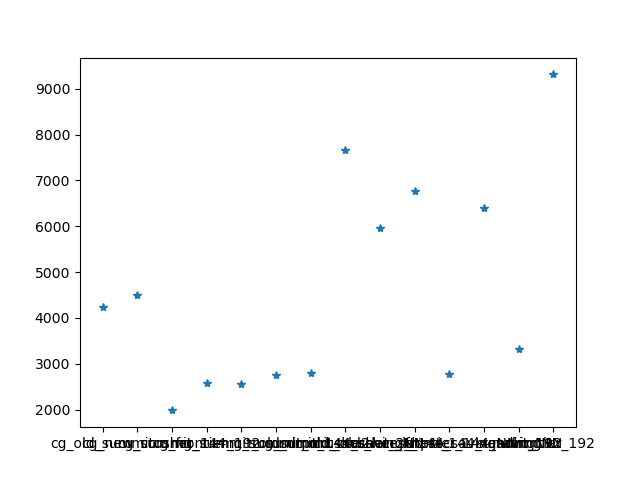

In [17]:
y_options=['mass-01', 'mass-02', 'mass-03', 'mass-04-10', 'mass-11-20',
       'startup', 'loading', 'mg-setup', 'solve-time', 'make/save-src',
       'contractions', 'summed-time', 'quda-total-time', 'milc-total-time',
       'error', 'mass-01-10']


def f_compare_plot(df,y,x='name'):
    # df.plot(x=x,y=y,kind='line',marker='D')
    
    display(df[[x,y]])
    
    x=df.name.values
    y=df[y].values
    print(x,y)
    plt.figure()
    plt.plot(x,y,marker='*',linestyle='')
    # plt.plot(y,marker='*')
    # plt.legend()
    plt.show()
    
# df.plot(x='name',y='summed-time',kind='line',marker='*')
f_compare_plot(df,'summed-time','name')

In [18]:
interact(f_compare_plot,df=fixed(df),y=y_options,x=fixed('name'))

interactive(children=(Dropdown(description='y', options=('mass-01', 'mass-02', 'mass-03', 'mass-04-10', 'mass-…

<function __main__.f_compare_plot(df, y, x='name')>

In [19]:
def f_plot_together(df,labels_lst,markers_lst): 
    plt.figure()
    x=df.name.values

    for label,marker in zip(labels_lst,markers_lst):
        y=df[label].values
        plt.plot(x,y,marker=marker,label=label)

    plt.legend()


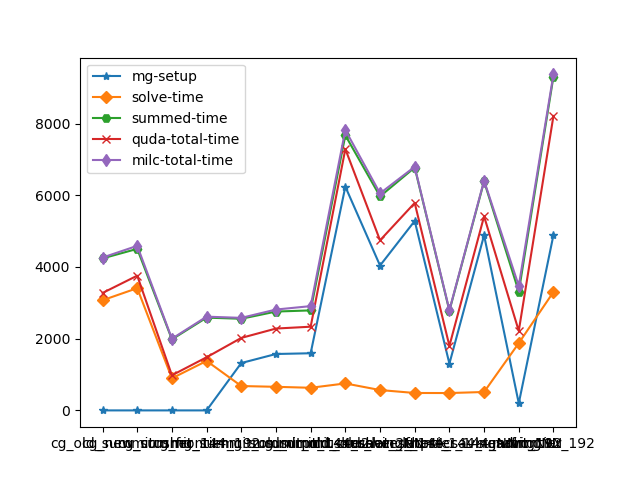

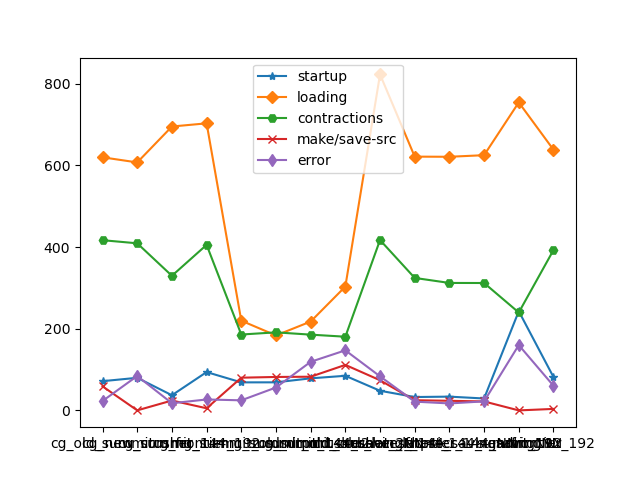

In [20]:
markers=['*','D','H','x','d','p','1','2','h','v']
labels=['startup', 'loading', 'mg-setup', 'solve-time', 'make/save-src',
       'contractions', 'summed-time', 'quda-total-time', 'milc-total-time',
       'error']

labels1=['mg-setup', 'solve-time','summed-time', 'quda-total-time', 'milc-total-time']

labels2=['startup', 'loading','contractions','make/save-src','error']

f_plot_together(df,labels1,markers)
f_plot_together(df,labels2,markers)
